## Importing Basic Libraries 

In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import os
from tensorflow import keras
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB0, ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess_input
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess_input
from sklearn.metrics import classification_report

# Prepare The Data

## Read Dataset 

In [2]:
path = 'eye/dataset'
dataset_path = os.listdir(path)
class_labels = []

In [3]:
class_labels = []

for item in dataset_path:
    all_classes = os.listdir(path + '/'+ item)
    
    for room in all_classes:
        class_labels.append((item, str(path + '/' + item )+'/'+ room))

In [4]:
df = pd.DataFrame(data=class_labels, columns=['Labels','image'])
print(df.head())
print(df.tail())

     Labels                                image
0  cataract      eye/dataset/cataract/0_left.jpg
1  cataract    eye/dataset/cataract/103_left.jpg
2  cataract  eye/dataset/cataract/1062_right.jpg
3  cataract   eye/dataset/cataract/1083_left.jpg
4  cataract  eye/dataset/cataract/1084_right.jpg
      Labels                             image
4212  normal    eye/dataset/normal/8_right.jpg
4213  normal   eye/dataset/normal/939_left.jpg
4214  normal  eye/dataset/normal/939_right.jpg
4215  normal   eye/dataset/normal/951_left.jpg
4216  normal  eye/dataset/normal/951_right.jpg


## Preprocess labels

In [5]:
y = df['Labels'].values
y_labelencoder = LabelEncoder()
y = y_labelencoder.fit_transform(y)
y = y.reshape(-1, 1)
ct = ColumnTransformer([('my_ohe', OneHotEncoder(), [0])], remainder='passthrough')
Y = ct.fit_transform(y).toarray()

## Preprocess images

In [6]:
path1 = path +'/'
im_size = 224
images = []
labels = []

for i in dataset_path:
    data_path = os.path.join(path1, i)
    filenames = [f for f in os.listdir(data_path)]
    
    for f in filenames:
        img_path = os.path.join(data_path, f)
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=(im_size, im_size))
        img = tf.keras.preprocessing.image.img_to_array(img)
        images.append(img)
        labels.append(i)

images = np.array(images)
images = images.astype('float32') / 255.0

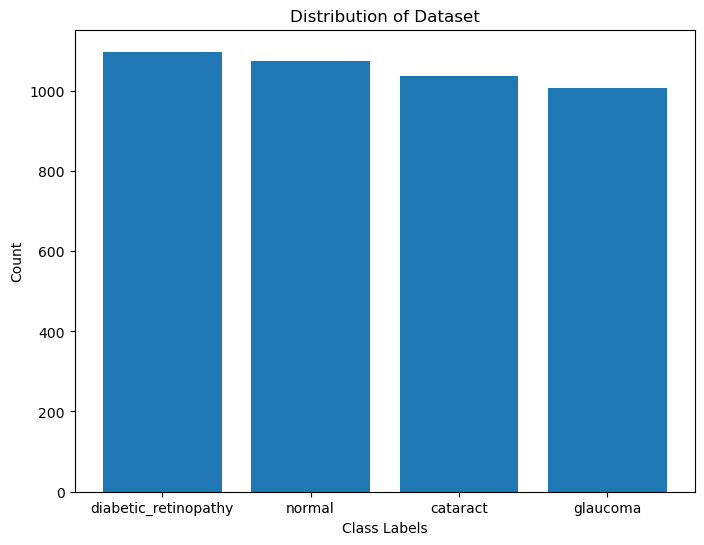

In [7]:
class_counts = df['Labels'].value_counts()

plt.figure(figsize=(8, 6))
plt.bar(class_counts.index, class_counts.values)
plt.xlabel('Class Labels')
plt.ylabel('Count')
plt.title('Distribution of Dataset')
plt.show()

## Split the dataset 

In [8]:
train_x, test_x, train_y, test_y = train_test_split(images, Y, test_size=0.2, random_state=415)
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.125, random_state=415)

## Data Augmentation

In [9]:

def custom_preprocess_input(img):
    img_resnet = resnet_preprocess_input(img.copy())
    img_efficientnet = efficientnet_preprocess_input(img.copy())
    return img_resnet, img_efficientnet

datagen = ImageDataGenerator(
    rotation_range=20,
    preprocessing_function=custom_preprocess_input
)

In [10]:
augmented_images = []
augmented_labels = []
for image, label in zip(train_x, train_y):
    augmented_images.append(image)
    augmented_labels.append(label)

    transformed_image = datagen.random_transform(image)
    augmented_images.append(transformed_image)
    augmented_labels.append(label)

In [11]:
train_x = np.array(augmented_images)
train_y = np.array(augmented_labels)

In [12]:
train_x, train_y = shuffle(train_x, train_y, random_state=1)
print("Train images shape:", train_x.shape)
print("Train labels shape:", train_y.shape)
print("Test images shape:", test_x.shape)
print("Test labels shape:", test_y.shape)

Train images shape: (5902, 224, 224, 3)
Train labels shape: (5902, 4)
Test images shape: (844, 224, 224, 3)
Test labels shape: (844, 4)


# Model

In [13]:
NUM_CLASSES = 4
IMG_SIZE = 224
num_epochs = 10
inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

## EfficientNetB0

In [14]:
effnet_model = EfficientNetB0(include_top=False, weights="imagenet", classes=NUM_CLASSES)(inputs)
effnet_model = layers.GlobalAveragePooling2D()(effnet_model)
effnet_model = layers.Dense(NUM_CLASSES, activation="softmax")(effnet_model)
effnet_model = tf.keras.Model(inputs, effnet_model)

### ADAM

In [15]:
effnet_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [16]:
effnet_history_adam = effnet_model.fit(train_x, train_y, epochs=num_epochs, validation_data=(val_x, val_y),verbose=1)

Epoch 1/10
185/185 [==============================] - 628s 3s/step - loss: 0.3850 - accuracy: 0.8534 - val_loss: 11.5241 - val_accuracy: 0.2464
Epoch 2/10
185/185 [==============================] - 596s 3s/step - loss: 0.2086 - accuracy: 0.9251 - val_loss: 6.2037 - val_accuracy: 0.2464
Epoch 3/10
185/185 [==============================] - 598s 3s/step - loss: 0.1443 - accuracy: 0.9498 - val_loss: 5.8651 - val_accuracy: 0.2630
Epoch 4/10
185/185 [==============================] - 598s 3s/step - loss: 0.1179 - accuracy: 0.9587 - val_loss: 12.2705 - val_accuracy: 0.2464
Epoch 5/10
185/185 [==============================] - 650s 4s/step - loss: 0.0808 - accuracy: 0.9719 - val_loss: 6103.9673 - val_accuracy: 0.2346
Epoch 6/10
185/185 [==============================] - 679s 4s/step - loss: 0.0750 - accuracy: 0.9737 - val_loss: 4.8984 - val_accuracy: 0.2630
Epoch 7/10
185/185 [==============================] - 608s 3s/step - loss: 0.0374 - accuracy: 0.9870 - val_loss: 899.7612 - val_accuracy:

In [36]:
effnet_predictions_adam = effnet_model.predict(test_x)

27/27 [==============================] - 26s 914ms/step


In [35]:
effnet_report_adam = classification_report(np.argmax(test_y, axis=1), np.argmax(effnet_predictions_adam, axis=1), zero_division=0)
print(effnet_report_adam)

              precision    recall  f1-score   support

           0       0.27      0.25      0.26       220
           1       0.24      0.73      0.37       208
           2       0.26      0.03      0.05       203
           3       0.00      0.00      0.00       213

    accuracy                           0.25       844
   macro avg       0.19      0.25      0.17       844
weighted avg       0.19      0.25      0.17       844



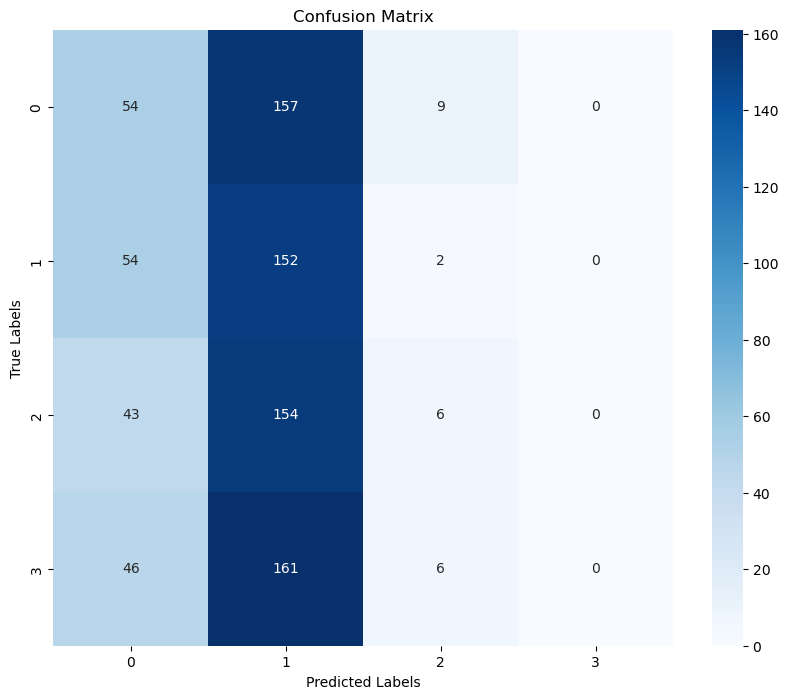

In [39]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

effnet_predictions_labels = np.argmax(effnet_predictions_adam, axis=1)
true_labels = np.argmax(test_y, axis=1)

cm = confusion_matrix(true_labels, effnet_predictions_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=[0, 1, 2, 3], yticklabels=[0, 1, 2, 3])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

### SGD

In [19]:
effnet_model_sgd = tf.keras.models.clone_model(effnet_model)
effnet_model_sgd.compile(optimizer="SGD", loss="categorical_crossentropy", metrics=["accuracy"])

In [20]:
effnet_history_sgd = effnet_model_sgd.fit(train_x, train_y, epochs=num_epochs, validation_data=(val_x, val_y),verbose=1)

Epoch 1/10
185/185 [==============================] - 615s 3s/step - loss: 1.3260 - accuracy: 0.3744 - val_loss: 1.4771 - val_accuracy: 0.2630
Epoch 2/10
185/185 [==============================] - 596s 3s/step - loss: 1.1257 - accuracy: 0.5015 - val_loss: 1.9951 - val_accuracy: 0.2630
Epoch 3/10
185/185 [==============================] - 597s 3s/step - loss: 0.9367 - accuracy: 0.5930 - val_loss: 2.8216 - val_accuracy: 0.2630
Epoch 4/10
185/185 [==============================] - 594s 3s/step - loss: 0.7967 - accuracy: 0.6572 - val_loss: 0.9457 - val_accuracy: 0.5711
Epoch 5/10
185/185 [==============================] - 595s 3s/step - loss: 0.7140 - accuracy: 0.6920 - val_loss: 0.7196 - val_accuracy: 0.6825
Epoch 6/10
185/185 [==============================] - 594s 3s/step - loss: 0.6386 - accuracy: 0.7301 - val_loss: 0.6694 - val_accuracy: 0.7014
Epoch 7/10
185/185 [==============================] - 596s 3s/step - loss: 0.5883 - accuracy: 0.7552 - val_loss: 0.8037 - val_accuracy: 0.6801

In [21]:
effnet_predictions_sgd = effnet_model_sgd.predict(test_x)

27/27 [==============================] - 19s 648ms/step


In [22]:
effnet_report_sgd = classification_report(np.argmax(test_y, axis=1), np.argmax(effnet_predictions_sgd, axis=1))
print(effnet_report_sgd)

              precision    recall  f1-score   support

           0       0.86      0.41      0.56       220
           1       0.96      0.99      0.97       208
           2       0.62      0.57      0.59       203
           3       0.58      0.92      0.71       213

    accuracy                           0.72       844
   macro avg       0.75      0.72      0.71       844
weighted avg       0.76      0.72      0.71       844



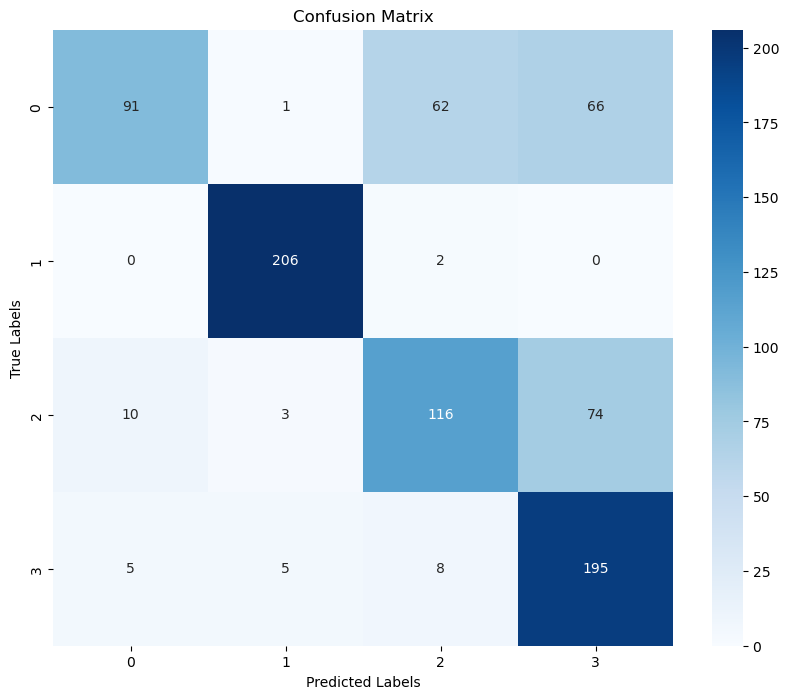

In [40]:
effnet_predictions_labels = np.argmax(effnet_predictions_sgd, axis=1)
true_labels = np.argmax(test_y, axis=1)

cm = confusion_matrix(true_labels, effnet_predictions_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=[0, 1, 2, 3], yticklabels=[0, 1, 2, 3])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

## ResNet50

In [23]:
resnet_model = ResNet50(include_top=False, weights="imagenet", classes=NUM_CLASSES)(inputs)
resnet_model = layers.GlobalAveragePooling2D()(resnet_model)
resnet_model = layers.Dense(NUM_CLASSES, activation="softmax")(resnet_model)
resnet_model = tf.keras.Model(inputs, resnet_model)

### ADAM

In [24]:
resnet_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [25]:
resnet_history_adam = resnet_model.fit(train_x, train_y, epochs=num_epochs, validation_data=(val_x, val_y),verbose=1)

Epoch 1/10
185/185 [==============================] - 1017s 5s/step - loss: 0.5168 - accuracy: 0.8236 - val_loss: 3.0454 - val_accuracy: 0.2654
Epoch 2/10
185/185 [==============================] - 996s 5s/step - loss: 0.2554 - accuracy: 0.9117 - val_loss: 2.1067 - val_accuracy: 0.2441
Epoch 3/10
185/185 [==============================] - 1019s 6s/step - loss: 0.1974 - accuracy: 0.9305 - val_loss: 3.9913 - val_accuracy: 0.2464
Epoch 4/10
185/185 [==============================] - 1001s 5s/step - loss: 0.1712 - accuracy: 0.9414 - val_loss: 2.8800 - val_accuracy: 0.3673
Epoch 5/10
185/185 [==============================] - 998s 5s/step - loss: 0.1738 - accuracy: 0.9368 - val_loss: 1.3001 - val_accuracy: 0.6090
Epoch 6/10
185/185 [==============================] - 1058s 6s/step - loss: 0.1371 - accuracy: 0.9482 - val_loss: 1.0080 - val_accuracy: 0.6919
Epoch 7/10
185/185 [==============================] - 1022s 6s/step - loss: 0.1166 - accuracy: 0.9610 - val_loss: 0.7182 - val_accuracy: 0

In [26]:
resnet_predictions_adam = resnet_model.predict(test_x)

27/27 [==============================] - 32s 1s/step


In [33]:
resnet_report_adam = classification_report(np.argmax(test_y, axis=1), np.argmax(resnet_predictions_adam, axis=1))
print(resnet_report_adam)

              precision    recall  f1-score   support

           0       0.86      0.91      0.88       220
           1       0.99      1.00      0.99       208
           2       0.92      0.64      0.76       203
           3       0.75      0.92      0.83       213

    accuracy                           0.87       844
   macro avg       0.88      0.87      0.87       844
weighted avg       0.88      0.87      0.87       844



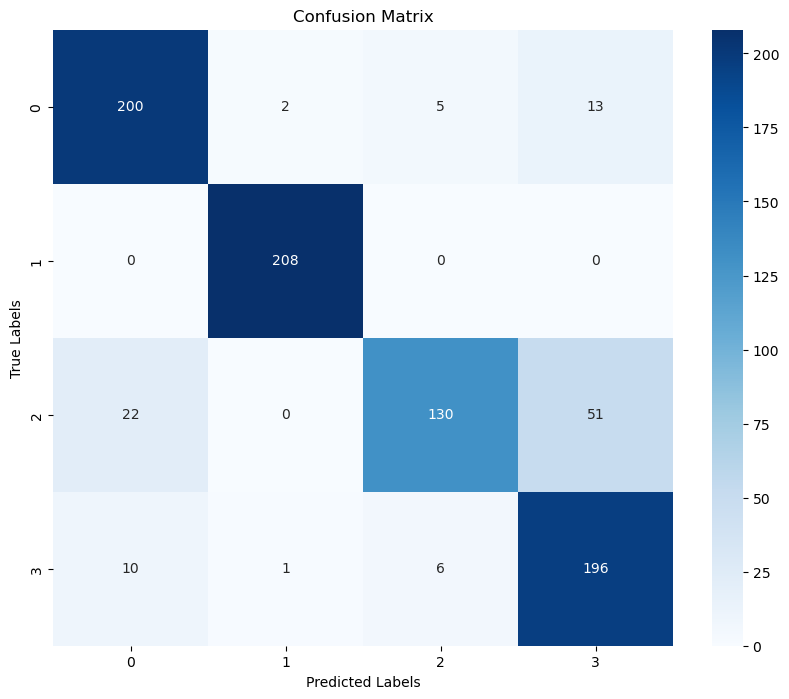

In [41]:
resnet_predictions_labels = np.argmax(resnet_predictions_adam, axis=1)
true_labels = np.argmax(test_y, axis=1)

cm = confusion_matrix(true_labels, resnet_predictions_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=[0, 1, 2, 3], yticklabels=[0, 1, 2, 3])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

### SGD

In [28]:
resnet_model_sgd = tf.keras.models.clone_model(resnet_model)
resnet_model_sgd.compile(optimizer="SGD", loss="categorical_crossentropy", metrics=["accuracy"])

In [29]:
resnet_history_sgd = resnet_model_sgd.fit(train_x, train_y, epochs=num_epochs, validation_data=(val_x, val_y),verbose=1)

Epoch 1/10
185/185 [==============================] - 990s 5s/step - loss: 1.8126 - accuracy: 0.3900 - val_loss: 1.6531 - val_accuracy: 0.2678
Epoch 2/10
185/185 [==============================] - 976s 5s/step - loss: 0.9727 - accuracy: 0.6073 - val_loss: 1.6903 - val_accuracy: 0.2938
Epoch 3/10
185/185 [==============================] - 982s 5s/step - loss: 0.7667 - accuracy: 0.6752 - val_loss: 1.0427 - val_accuracy: 0.5735
Epoch 4/10
185/185 [==============================] - 1210s 7s/step - loss: 0.6648 - accuracy: 0.7142 - val_loss: 4.3956 - val_accuracy: 0.4265
Epoch 5/10
185/185 [==============================] - 1014s 5s/step - loss: 0.5753 - accuracy: 0.7621 - val_loss: 1.5307 - val_accuracy: 0.6445
Epoch 6/10
185/185 [==============================] - 980s 5s/step - loss: 0.5297 - accuracy: 0.7821 - val_loss: 0.5016 - val_accuracy: 0.7820
Epoch 7/10
185/185 [==============================] - 978s 5s/step - loss: 0.4640 - accuracy: 0.8099 - val_loss: 8.2838 - val_accuracy: 0.37

In [30]:
resnet_predictions_sgd = resnet_model_sgd.predict(test_x)

27/27 [==============================] - 45s 2s/step


In [34]:
resnet_report_sgd = classification_report(np.argmax(test_y, axis=1), np.argmax(resnet_predictions_sgd, axis=1))
print(resnet_report_sgd)

              precision    recall  f1-score   support

           0       0.71      0.85      0.78       220
           1       0.93      1.00      0.96       208
           2       0.67      0.68      0.67       203
           3       0.70      0.50      0.58       213

    accuracy                           0.76       844
   macro avg       0.75      0.76      0.75       844
weighted avg       0.75      0.76      0.75       844



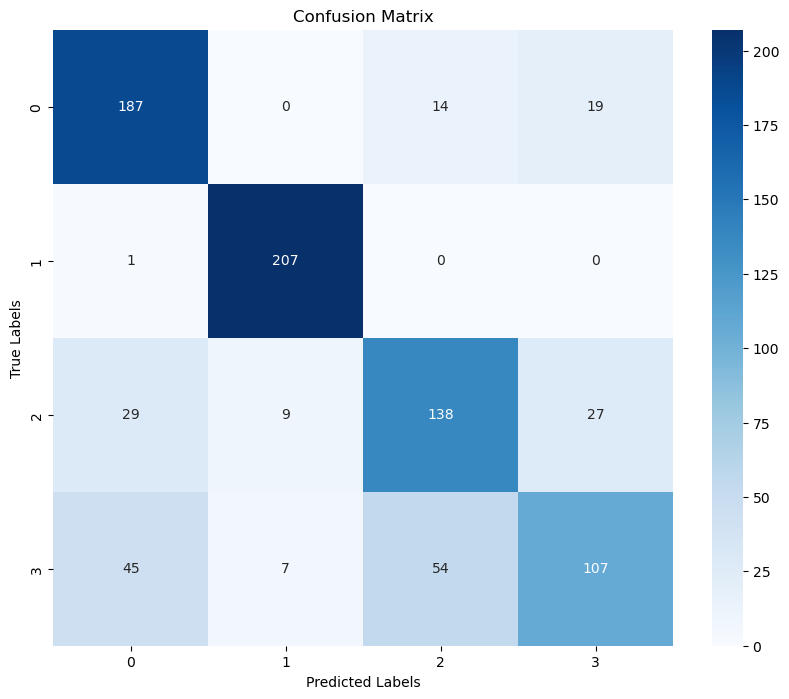

In [42]:
resnet_predictions_labels = np.argmax(resnet_predictions_sgd, axis=1)
true_labels = np.argmax(test_y, axis=1)

cm = confusion_matrix(true_labels, resnet_predictions_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=[0, 1, 2, 3], yticklabels=[0, 1, 2, 3])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

## Evaluate

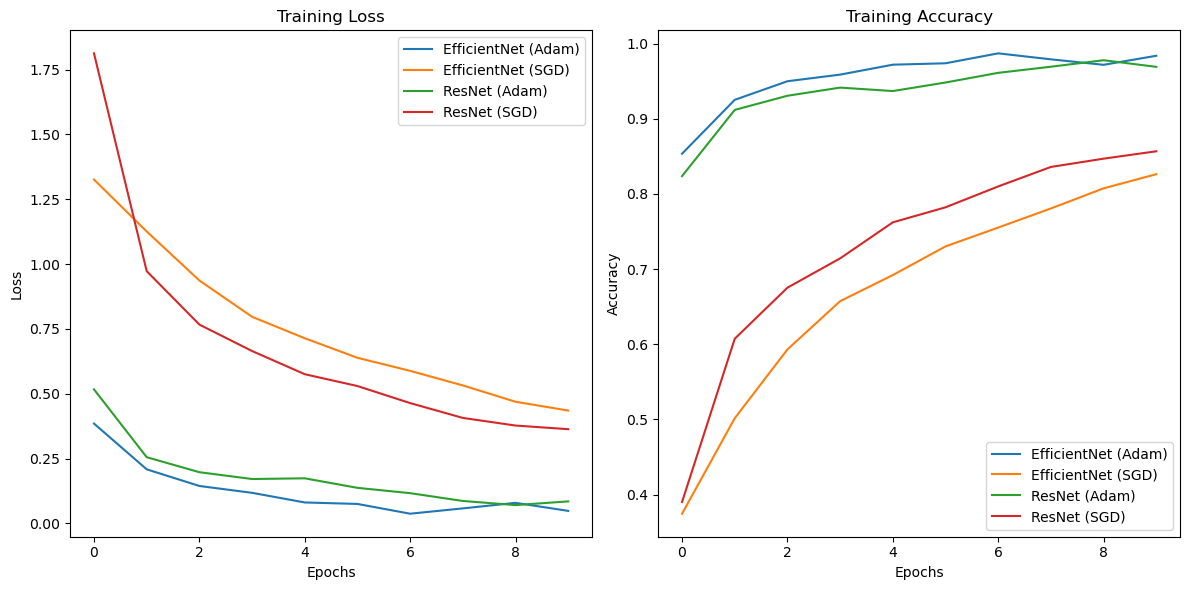

In [32]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(effnet_history_adam.history["loss"], label="EfficientNet (Adam)")
plt.plot(effnet_history_sgd.history["loss"], label="EfficientNet (SGD)")
plt.plot(resnet_history_adam.history["loss"], label="ResNet (Adam)")
plt.plot(resnet_history_sgd.history["loss"], label="ResNet (SGD)")
plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(effnet_history_adam.history["accuracy"], label="EfficientNet (Adam)")
plt.plot(effnet_history_sgd.history["accuracy"], label="EfficientNet (SGD)")
plt.plot(resnet_history_adam.history["accuracy"], label="ResNet (Adam)")
plt.plot(resnet_history_sgd.history["accuracy"], label="ResNet (SGD)")
plt.title("Training Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()